In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from src.vit_model.mae import MaskedAutoencoderViT

In [2]:
model = MaskedAutoencoderViT(
    img_size=224,
    patch_size=16,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_depth=4,
    mlp_ratio=4,
    decoder_num_heads=12,
    decoder_embed_dim=384,
)

In [3]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

93,564,288 total parameters.


In [4]:
# load pretrained weights
# print(model.state_dict().keys())
new_state_dict = torch.load('mae_pretrain_vit_base.pth')['model']

# copy and freeze the parameters:
for name, param in model.named_parameters():
    if name in new_state_dict:
        param.requires_grad = False
        param.copy_(new_state_dict[name])
    else:
        print(f'not copied: {name}')



not copied: mask_token
not copied: decoder_pos_embed
not copied: decoder_embed.weight
not copied: decoder_embed.bias
not copied: decoder_blocks.0.norm1.weight
not copied: decoder_blocks.0.norm1.bias
not copied: decoder_blocks.0.attn.qkv.weight
not copied: decoder_blocks.0.attn.qkv.bias
not copied: decoder_blocks.0.attn.proj.weight
not copied: decoder_blocks.0.attn.proj.bias
not copied: decoder_blocks.0.norm2.weight
not copied: decoder_blocks.0.norm2.bias
not copied: decoder_blocks.0.mlp.fc1.weight
not copied: decoder_blocks.0.mlp.fc1.bias
not copied: decoder_blocks.0.mlp.fc2.weight
not copied: decoder_blocks.0.mlp.fc2.bias
not copied: decoder_blocks.1.norm1.weight
not copied: decoder_blocks.1.norm1.bias
not copied: decoder_blocks.1.attn.qkv.weight
not copied: decoder_blocks.1.attn.qkv.bias
not copied: decoder_blocks.1.attn.proj.weight
not copied: decoder_blocks.1.attn.proj.bias
not copied: decoder_blocks.1.norm2.weight
not copied: decoder_blocks.1.norm2.bias
not copied: decoder_blocks.

In [5]:
#import vgg 16
import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self, feature_layers = [3, 8, 15, 22, 29]):
        super().__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights).features
        
        self.vgg_slices = [self.vgg[:layer].eval() for layer in feature_layers]
        # print layers
        # for i, layer in enumerate(self.vgg_slices):
        #     print(f'Layer {i}: {layer}')
            
        # for i, layer in enumerate(self.vgg):
        #     print(f'Layer {i}: {layer}')
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, y_pred,y_true):
        if y_pred.size(1) == 1:
            y_pred = y_pred.repeat(1, 3, 1, 1)
        if y_true.size(1) == 1:
            y_true = y_true.repeat(1, 3, 1, 1)
        loss = 0
        x = y_pred
        y = y_true
        for i, vgg_slice in enumerate(self.vgg_slices):
            x = vgg_slice(y_pred)
            y = vgg_slice(y_true)
            print(x.shape, y.shape)
            loss += F.mse_loss(x, y)
        return loss
        
    

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np



    

In [7]:
from torch.utils.data import DataLoader,Dataset
import os

class EuroSATDataset(Dataset):
    def __init__(self, path):
        self.file_list = os.listdir(path)
        self.path = path
        self.bands = 13
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        with rasterio.open(os.path.join(self.path, self.file_list[idx])) as src:
            img = src.read()
            img = torch.tensor(img).float()
            img = img / 255.0
            img = img * 2.0 - 1.0
            img = img.unsqueeze(0)
            img = F.interpolate(img, size=(224, 224))
            img = img.squeeze(0)
            x = img[3:5+1]
            y = img[11].unsqueeze(0)
            print(x.shape, y.shape)
            return x, y
        
        

In [8]:
import torch.optim as optim

train_dataset = EuroSATDataset('data/EuroSAT_MS/EuroSAT_MS/full')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = PerceptualLoss()
epochs = 1

In [12]:
for i in range(epochs):
    for batch in train_loader:
        x,y = batch
        print(x.shape, y.shape)
        optimizer.zero_grad()
        y_pred,_,_ = model(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        print(loss)

torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
torch.Size([4, 64, 224, 224]) torch.Size([4, 64, 224, 224])
torch.Size([4, 128, 112, 112]) torch.Size([4, 128, 112, 112])
torch.Size([4, 256, 56, 56]) torch.Size([4, 256, 56, 56])
torch.Size([4, 512, 28, 28]) torch.Size([4, 512, 28, 28])
torch.Size([4, 512, 14, 14]) torch.Size([4, 512, 14, 14])
tensor(4070.1941, grad_fn=<AddBackward0>)
torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
torch.Size([4, 64, 224, 224]) torch.Size([4, 64, 224, 224])
torch.Size([4, 128, 112, 112]) torch.Size([4, 128, 112, 112])
torch.Si

KeyboardInterrupt: 

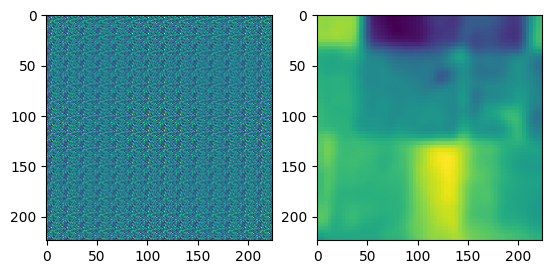

In [15]:

with torch.no_grad():
    with rasterio.open('data/EuroSAT_MS/EuroSAT_MS/full/AnnualCrop_1.tif') as src:
        img = src.read()
        img = torch.tensor(img).float()
        img = img / 255.0
        img = img * 2.0 - 1.0
        img = img.unsqueeze(0)
        img = F.interpolate(img, size=(224, 224))
        img = img.squeeze(0)
        x = img[3:5+1].unsqueeze(0)
        y = img[11].unsqueeze(0).unsqueeze(0)
        y_pred,_,_ = model(x)
        # plot it next to each other
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(y_pred[0,0].cpu().numpy())
        axs[1].imshow(y[0,0].cpu().numpy())
        plt.show()
        